In [2]:
!pip install pandas numpy matplotlib sklearn tensorflow

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 5.7261e-05 - val_loss: 0.0022
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.3923e-06 - val_loss: 0.0030
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 2.1130e-06 - val_loss: 0.0014
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 2.1046e-06 - val_loss: 0.0027
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 2.4163e-06 - val_loss: 7.0964e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 2.1378e-06 - val_loss: 0.0018
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.9872e-06 - val_loss: 0.0029
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 2.3577e-06 - val_loss: 0.0017
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 1.9126e-06 - val_loss: 0.0021
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.3278e-06 - val_loss: 0.0011
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.2343e-06 - val_loss: 9

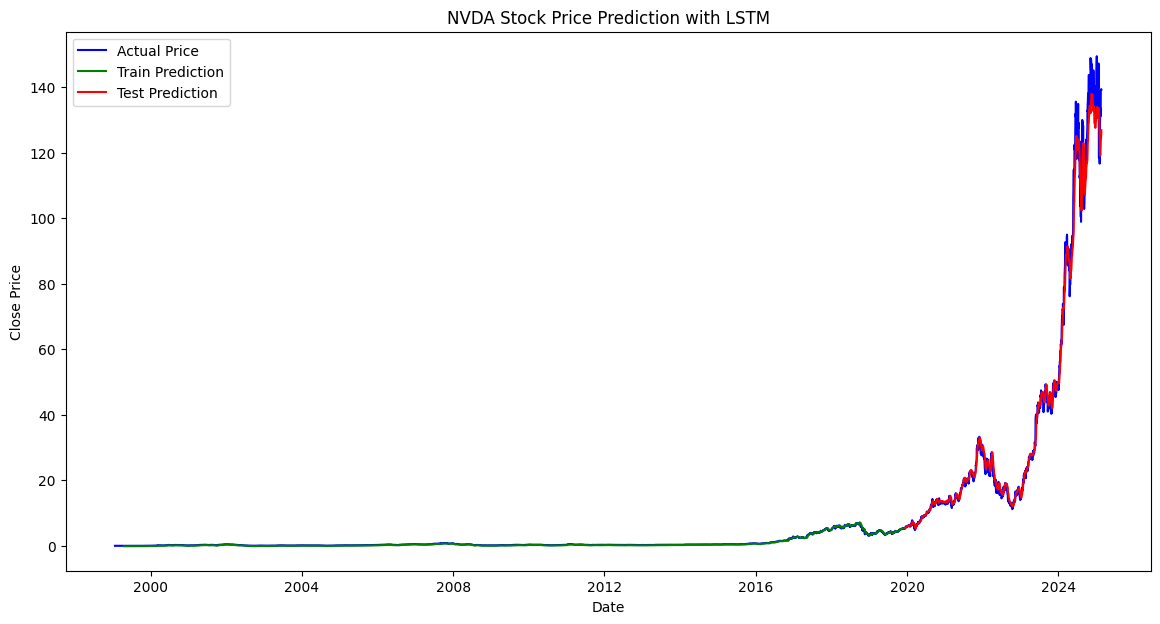

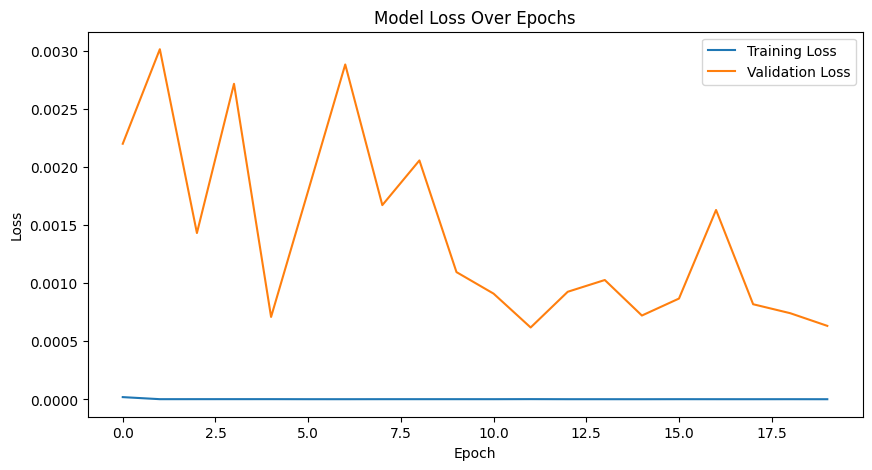

In [3]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 2: Load and Preprocess Data
# Load the CSV file "NVDA.csv" from your local directory
df = pd.read_csv('NVDA.csv')  # Ensure 'NVDA.csv' is in your working directory

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# We'll use only the 'Close' price for this analysis
close_prices = df['Close'].values.reshape(-1, 1)

# Step 3: Feature Engineering
# Normalize the data (scale between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences for LSTM (e.g., use past 60 days to predict the next day)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer for predicting the closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the Model
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Step 7: Visualize Results
# Prepare data for plotting
train_plot = np.empty_like(close_prices)
train_plot[:, :] = np.nan
train_plot[seq_length:len(train_predict) + seq_length, :] = train_predict

test_plot = np.empty_like(close_prices)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + seq_length:len(close_prices), :] = test_predict

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, close_prices, label='Actual Price', color='blue')
plt.plot(df.index, train_plot, label='Train Prediction', color='green')
plt.plot(df.index, test_plot, label='Test Prediction', color='red')
plt.title('NVDA Stock Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 4.6956e-05 - val_loss: 0.0058
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 2.6501e-06 - val_loss: 0.0026
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.3364e-06 - val_loss: 0.0047
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.6079e-06 - val_loss: 0.0036
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 2.2056e-06 - val_loss: 0.0025
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 2.1866e-06 - val_loss: 0.0016
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 1.9732e-06 - val_loss: 7.6461e-04
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.5602e-06 - val_loss: 6.4570e-04
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.3301e-06 - val_loss: 0.0015
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.9846e-06 - val_loss: 0.0012
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 1.7658e-06 - val_loss:

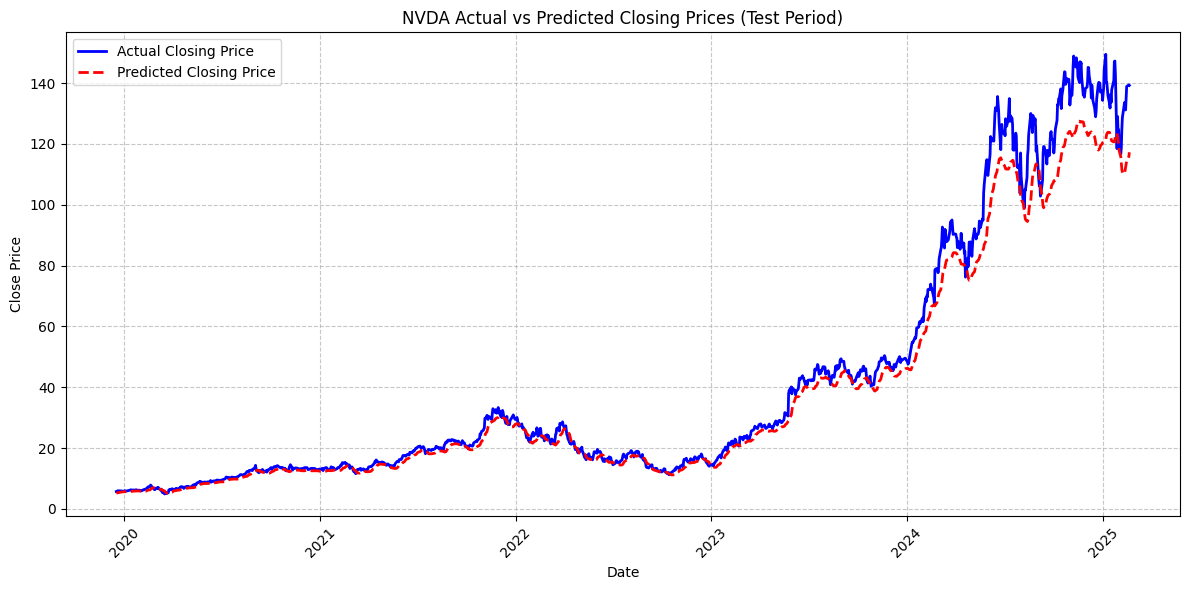

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 2: Load and Preprocess Data
df = pd.read_csv('NVDA.csv')  # Load your CSV file

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use only the 'Close' price
close_prices = df['Close'].values.reshape(-1, 1)

# Step 3: Feature Engineering
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the Model
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Test RMSE: {test_rmse:.4f}')

# Step 7: Simpler Visualization
# Get the dates corresponding to the test period
test_dates = df.index[train_size + seq_length:]

# Plot actual vs predicted prices for the test period only
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Closing Price', color='blue', linewidth=2)
plt.plot(test_dates, test_predict, label='Predicted Closing Price', color='red', linestyle='--', linewidth=2)
plt.title('NVDA Actual vs Predicted Closing Prices (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.4908 - loss: 0.6937 - val_accuracy: 0.5462 - val_loss: 0.6898
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.5462 - val_loss: 0.6920
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5104 - loss: 0.6932 - val_accuracy: 0.5462 - val_loss: 0.6919
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5159 - loss: 0.6929 - val_accuracy: 0.5462 - val_loss: 0.6916
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4903 - loss: 0.6932 - val_accuracy: 0.5462 - val_loss: 0.6898
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.5264 - loss: 0.6915 - val_accuracy: 0.4754 - val_loss: 0.6941
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5150 - loss: 0.6929 - val_accuracy: 0.5462 - val_loss: 0.6916
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5050 - loss: 0.6932 - val_accurac

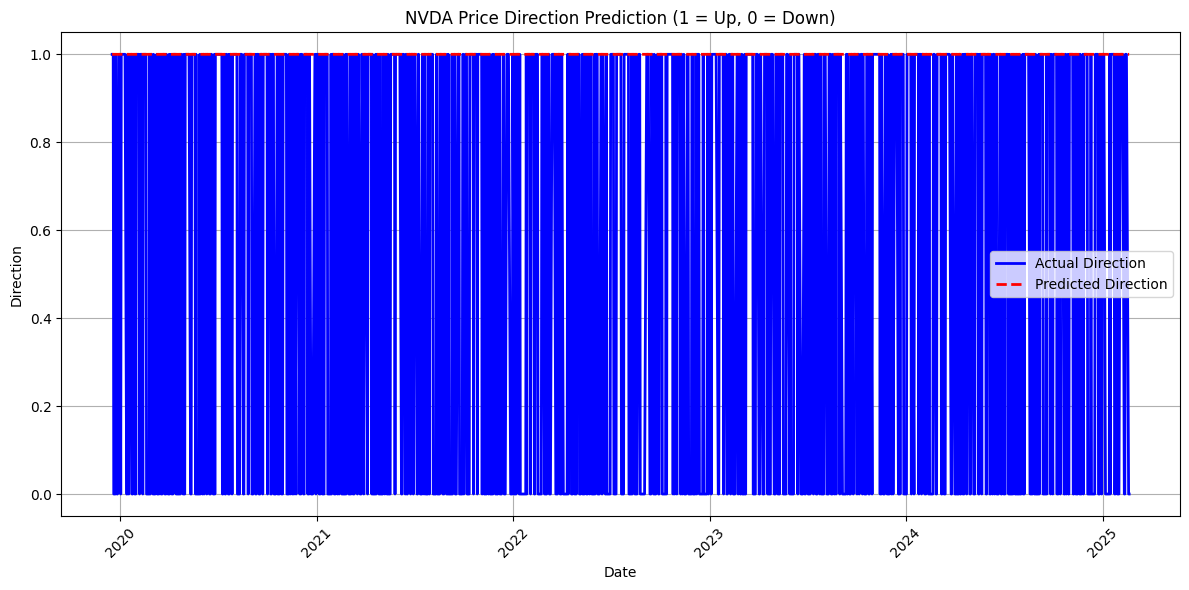

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load data
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create target: 1 if price increases, 0 if decreases
df['Direction'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

# Use 'Close' as input
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(df['Direction'].iloc[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1, activation='sigmoid'))  # Binary output

# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and evaluate
test_predict = model.predict(X_test)
test_predict = (test_predict > 0.5).astype(int)  # Threshold at 0.5
accuracy = accuracy_score(y_test, test_predict)
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize
test_dates = df.index[train_size + seq_length:]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual Direction', color='blue', linewidth=2)
plt.plot(test_dates, test_predict, label='Predicted Direction', color='red', linestyle='--', linewidth=2)
plt.title('NVDA Price Direction Prediction (1 = Up, 0 = Down)')
plt.xlabel('Date')
plt.ylabel('Direction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 12/20
163/163 ━━━━━━━━━━━━

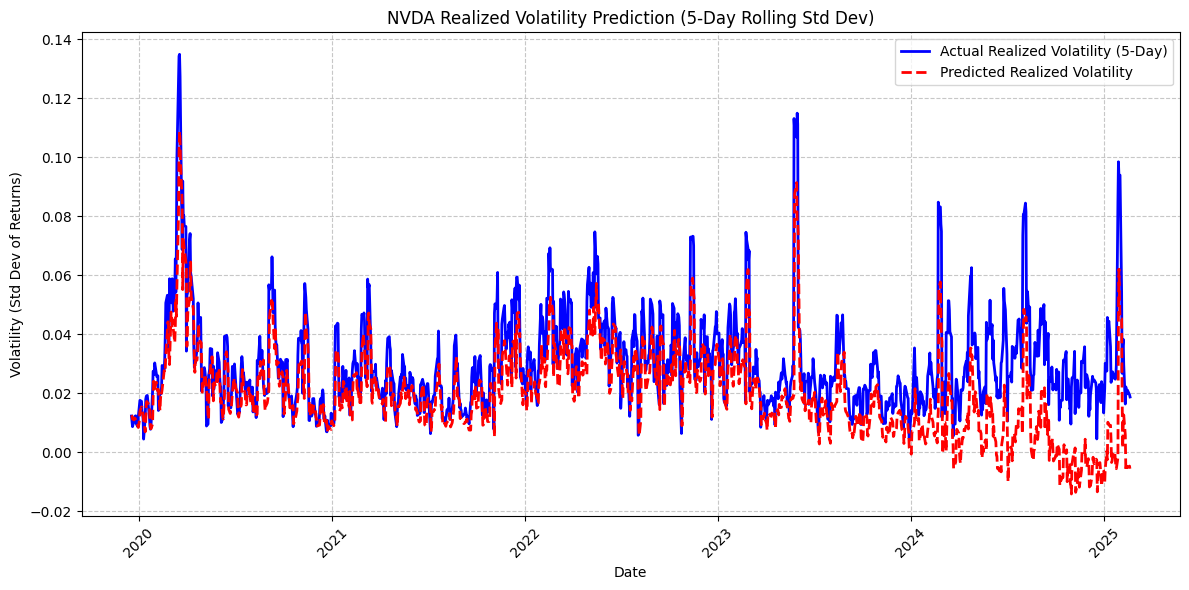

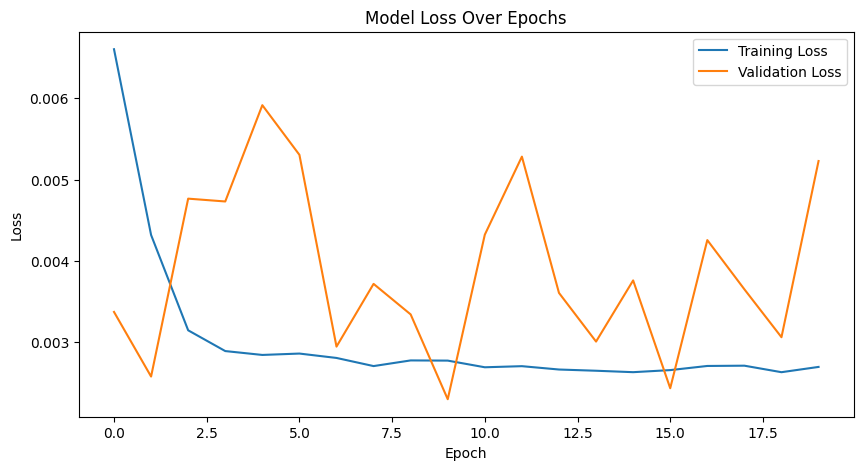

In [7]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 2: Load and Preprocess Data
df = pd.read_csv('NVDA.csv')  # Load your CSV file

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate daily returns and realized volatility (5-day rolling standard deviation)
df['Returns'] = df['Close'].pct_change()  # Daily percentage change
df['Volatility'] = df['Returns'].rolling(window=5).std()  # 5-day realized volatility
df.dropna(inplace=True)  # Drop rows with NaN (from rolling calculation and pct_change)

# Prepare multivariate features: Volatility, Close, Volume
features = df[['Volatility', 'Close', 'Volume']].values

# Step 3: Feature Engineering
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM (multivariate)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])  # All features (Volatility, Close, Volume)
        y.append(data[i + seq_length, 0])    # Predict Volatility (index 0)
    return np.array(X), np.array(y)

seq_length = 60  # Look back 60 days (adjustable)
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 3)))  # 3 features
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output: predicted volatility

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the Model
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
# Since we scaled all features together, we need to handle the transformation carefully
# Create a dummy array with 3 columns to inverse transform (only care about Volatility)
test_predict_full = np.zeros((len(test_predict), 3))  # 3 columns for features
test_predict_full[:, 0] = test_predict[:, 0]         # Volatility predictions
test_predict_inv = scaler.inverse_transform(test_predict_full)[:, 0]  # Extract Volatility

y_test_full = np.zeros((len(y_test), 3))
y_test_full[:, 0] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print(f'Test RMSE: {test_rmse:.4f}')

# Step 7: Visualize Results
# Get the dates for the test period
test_dates = df.index[train_size + seq_length:]

# Plot actual vs predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Realized Volatility (5-Day)', color='blue', linewidth=2)
plt.plot(test_dates, test_predict_inv, label='Predicted Realized Volatility', color='red', linestyle='--', linewidth=2)
plt.title('NVDA Realized Volatility Prediction (5-Day Rolling Std Dev)')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Plot training/validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 1.0672e-04 - val_loss: 0.0026
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - loss: 2.2136e-06 - val_loss: 0.0013
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - loss: 1.9369e-06 - val_loss: 0.0015
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 1.6327e-06 - val_loss: 0.0015
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 1.5824e-06 - val_loss: 0.0015
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 1.6196e-06 - val_loss: 6.9891e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - loss: 1.6282e-06 - val_loss: 6.4448e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 1.6542e-06 - val_loss: 0.0025
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 1.7506e-06 - val_loss: 0.0017
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 1.8240e-06 - val_loss: 0.0011
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 1.270

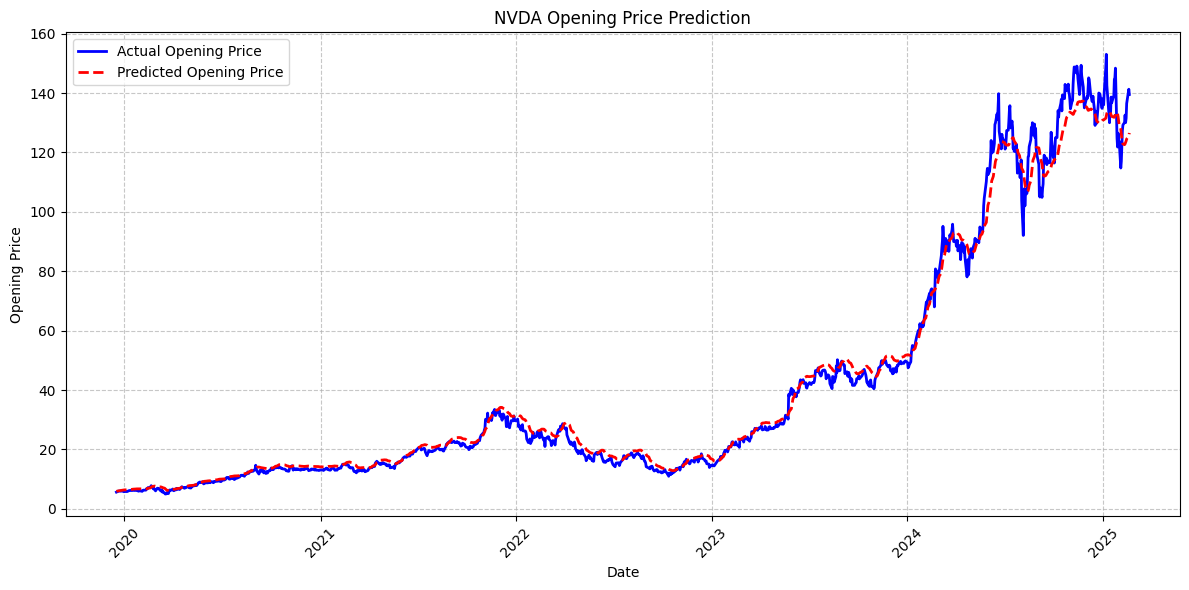

In [8]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Load and Preprocess Data
df = pd.read_csv('NVDA.csv')  # Load your CSV file

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Prepare multivariate features: Close, High, Low, Volume, Open (target last)
features = df[['Close', 'High', 'Low', 'Volume', 'Open']].values

# Step 3: Feature Engineering
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM (multivariate)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # Use Close, High, Low, Volume as input
        y.append(data[i + seq_length, -1])     # Predict Open (index 4)
    return np.array(X), np.array(y)

seq_length = 60  # Look back 60 days
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model (Enhanced)
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, 4)))  # 4 features
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dense(units=1))  # Output: predicted opening price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Step 6: Evaluate the Model
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
# Pad with zeros for other features to inverse transform
test_predict_full = np.zeros((len(test_predict), 5))  # 5 columns for features
test_predict_full[:, -1] = test_predict[:, 0]         # Open predictions
test_predict_inv = scaler.inverse_transform(test_predict_full)[:, -1]  # Extract Open

y_test_full = np.zeros((len(y_test), 5))
y_test_full[:, -1] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print(f'Test RMSE: {test_rmse:.4f}')

# Step 7: Predict the Next Opening Price (Latest Data)
# Use the last sequence from the full dataset
last_sequence = scaled_data[-seq_length:, :-1].reshape(1, seq_length, 4)
next_open_scaled = model.predict(last_sequence)
next_open_full = np.zeros((1, 5))
next_open_full[:, -1] = next_open_scaled[0]
next_open = scaler.inverse_transform(next_open_full)[0, -1]
last_date = df.index[-1]
next_date = last_date + pd.Timedelta(days=1)
print(f'Predicted Opening Price for {next_date.date()}: {next_open:.2f}')

# Step 8: Visualize Results
# Get the dates for the test period
test_dates = df.index[train_size + seq_length:]

# Plot actual vs predicted opening prices for the test period
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Opening Price', color='blue', linewidth=2)
plt.plot(test_dates, test_predict_inv, label='Predicted Opening Price', color='red', linestyle='--', linewidth=2)
plt.title('NVDA Opening Price Prediction')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - loss: 0.0023 - val_loss: 6.3419e-04
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - loss: 0.0026 - val_loss: 0.0082
Epoc

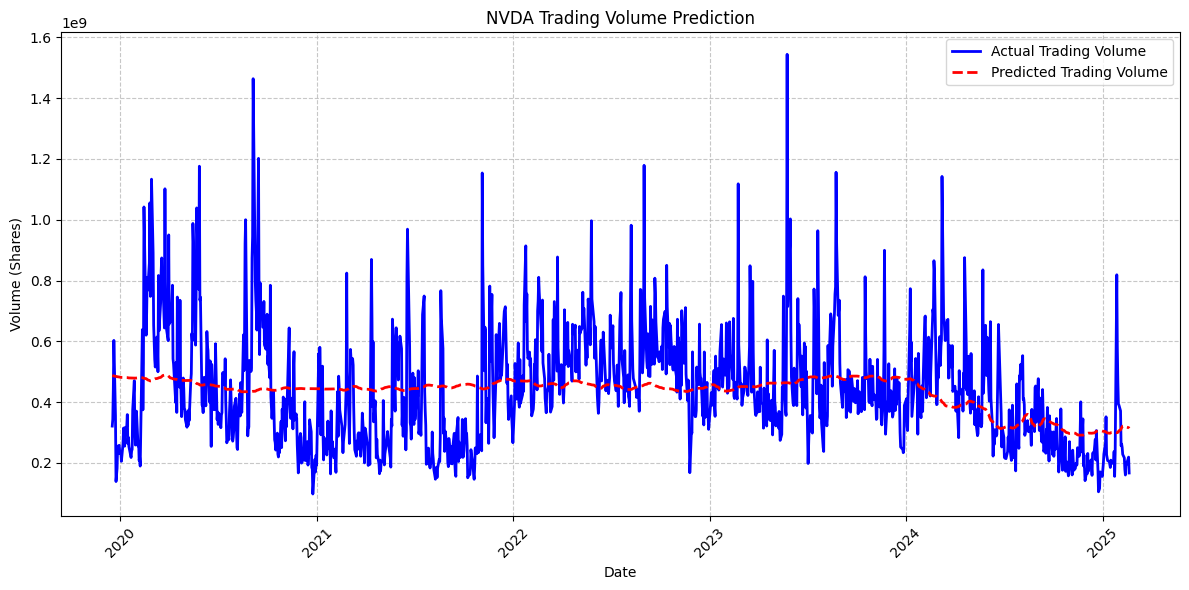

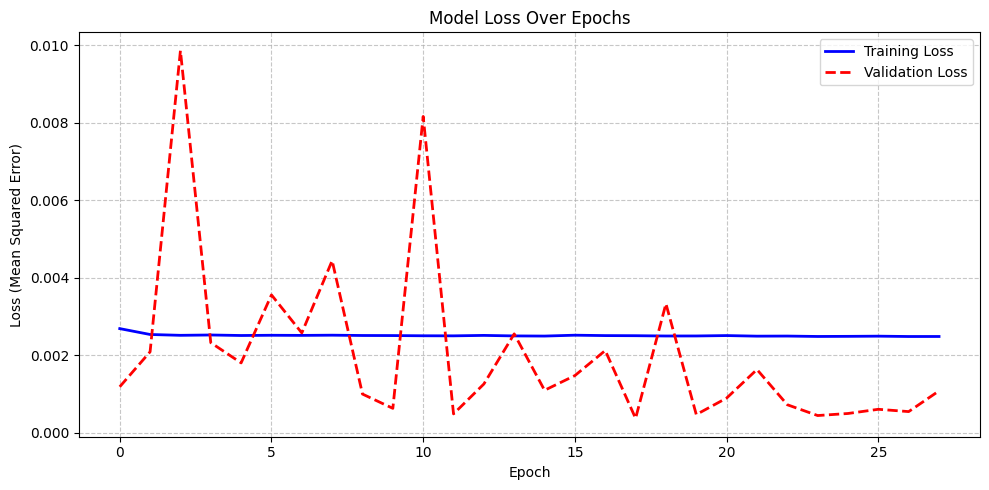

In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Step 2: Load and Preprocess Data
df = pd.read_csv('NVDA.csv')  # Load your CSV file

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Prepare multivariate features: Close, High, Low, Open, Volume (target last)
features = df[['Close', 'High', 'Low', 'Open', 'Volume']].values

# Step 3: Feature Engineering
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM (multivariate)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # Use Close, High, Low, Open as input
        y.append(data[i + seq_length, -1])     # Predict Volume (index 4)
    return np.array(X), np.array(y)

seq_length = 60  # Look back 60 days
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the Optimized LSTM Model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(seq_length, 4)))  # 4 features
model.add(Dropout(0.3))  # Increased dropout for regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))  # Output: predicted volume

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced from default 0.001
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping with longer patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Step 6: Evaluate the Model
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
test_predict_full = np.zeros((len(test_predict), 5))  # 5 columns for features
test_predict_full[:, -1] = test_predict[:, 0]         # Volume predictions
test_predict_inv = scaler.inverse_transform(test_predict_full)[:, -1]  # Extract Volume

y_test_full = np.zeros((len(y_test), 5))
y_test_full[:, -1] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print(f'Test RMSE: {test_rmse:.4f}')

# Step 7: Predict the Next Trading Volume (Latest Data)
last_sequence = scaled_data[-seq_length:, :-1].reshape(1, seq_length, 4)
next_volume_scaled = model.predict(last_sequence)
next_volume_full = np.zeros((1, 5))
next_volume_full[:, -1] = next_volume_scaled[0]
next_volume = scaler.inverse_transform(next_volume_full)[0, -1]
last_date = df.index[-1]
next_date = last_date + pd.Timedelta(days=1)
print(f'Predicted Trading Volume for {next_date.date()}: {next_volume:,.0f} shares')

# Step 8: Visualize Results
# Plot 1: Actual vs Predicted Trading Volume
test_dates = df.index[train_size + seq_length:]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Trading Volume', color='blue', linewidth=2)
plt.plot(test_dates, test_predict_inv, label='Predicted Trading Volume', color='red', linestyle='--', linewidth=2)
plt.title('NVDA Trading Volume Prediction')
plt.xlabel('Date')
plt.ylabel('Volume (Shares)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()